In [1]:
import os

In [2]:
import numpy as np
import pandas as pd 
import re
import nbimporter
from keras.preprocessing.text import Tokenizer 
from nltk import download
download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import Cleaned_datasets
from Attention import AttentionLayer
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
reviews = pd.read_csv(r"E:\Data.csv")
print(reviews.shape)
reviews.head()

(43, 3)


,Id,text,headlines
0,1.0,"The ability of sensing temperature in electronic circuits means the necessity to convert temperature change into measureable electric characteristics, e.g. resistance or voltage change. Several di...",Temperature measurement is one of the most important disciplines in sensor technology. Basically there are contactless and touchcontact measurement methods. This article will make an overview of t...
1,2.0,The Transistor is a three terminal solid state device which is formed by connecting two diodes back to back. Hence it has got two PN junctions. Three terminals are drawn out of the three semicondu...,A transistor is a semiconductor device used to amplify or switch electronic signals and electrical power. It is composed of semiconductor material usually with at least three terminals for connect...
2,3.0,A diode is a two-terminal semiconductor device that allows current to flow through in one direction only. It basically has negligible resistance on one end and high resistance on another to preven...,A diode is a two-terminal semiconductor device that allows current to flow through in one direction only. It basically has negligible resistance on one end and high resistance on another to preven...
3,4.0,"Capacitor, device for storing electrical energy, consisting of two conductors in close proximity and insulated from each other. A simple example of such a storage device is the parallel-plate capa...",The capacitor is a device in which electrical energy can be stored. It is an arrangement of two-conductor generally carrying charges of equal magnitudes and opposite sign and separated by an insul...
4,5.0,Metal Oxide Silicon Field Effect Transistors commonly known as MOSFETs are electronic devices that are used to switch or amplify voltages in circuits. It is a current controlled device and is cons...,The MOSFET (Metal Oxide Semiconductor Field Effect Transistor) transistor is a semiconductor device that is widely used for switching purposes and for the amplification of electronic signals in el...


In [4]:
# Check for any nulls values
reviews.isnull().sum()

Id           23
text          0
headlines     0
dtype: int64

In [5]:

# let's inspect some reviews
for i in range(5):
    print("Review: ",i+1)
    print(reviews.headlines[i])
    print('-'*80)
    print(reviews.text[i])
    print()

Review:  1
Temperature measurement is one of the most important disciplines in sensor technology. Basically there are contactless and touchcontact measurement methods. This article will make an overview of the possible temperature sensing technologies, but covers in details only the contacting temperature measurement, where the sensor element is in thermal contact with the object of which the temperature has to be measured.
--------------------------------------------------------------------------------
The ability of sensing temperature in electronic circuits means the necessity to convert temperature change into measureable electric characteristics, e.g. resistance or voltage change. Several different devices and technologies exist, that make it possible for the design engineers to integrate temperature sensing functions. One of them is the thermocouple technology. Thermo-couplers consist of two connected wires made of different metals. Changes in the temperature at their junction in

In [6]:
CURRENCIES = {
    "$": "USD", "zł": "PLN", "£": "GBP", "¥": "JPY", "฿": "THB", "₡": "CRC", "₦": "NGN","₩": "KRW",
    "₪": "ILS", "₫": "VND", "€": "EUR", "₱": "PHP", "₲": "PYG", "₴": "UAH", "₹": "INR",}
CURRENCY_REGEX = re.compile(
    "({})+".format("|".join(re.escape(c) for c in CURRENCIES.keys())))

EMAIL_REGEX = re.compile(
    r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))",
    flags=re.IGNORECASE | re.UNICODE,)

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions =          {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "i've": "i have"}


In [7]:
def clean_text(text, remove_stopwords = True):
    
    text = text.lower()
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = EMAIL_REGEX.sub(' ',text)
    text = CURRENCY_REGEX.sub(' ',text)
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])    
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r"'s\b","", text)
    text = re.sub(r'&amp;', '', text) 
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [8]:
cleaned_headlines = []
cleaned_text = []

for headlines in reviews['headlines']:
    cleaned_headlines.append(clean_text(headlines, remove_stopwords=False))
print("Headlines are complete.")

for text in reviews['text']:
    cleaned_text.append(clean_text(text))
print("Texts are complete.")

Headlines are complete.
Texts are complete.


In [9]:
# let's inspect some clean reviews
for i in range(4):
    print("Review: ",i+1)
    print(cleaned_headlines[i])
    print('-'*80)
    print(cleaned_text[i])
    print()

Review:  1
temperature measurement is one of the most important disciplines in sensor technology  basically there are contactless and touchcontact measurement methods  this article will make an overview of the possible temperature sensing technologies  but covers in details only the contacting temperature measurement  where the sensor element is in thermal contact with the object of which the temperature has to be measured 
--------------------------------------------------------------------------------
ability sensing temperature electronic circuits means necessity convert temperature change measureable electric characteristics e g resistance voltage change several different devices technologies exist make possible design engineers integrate temperature sensing functions one thermocouple technology thermo couplers consist two connected wires made different metals changes temperature junction induce change electromotive force emf effect called seebeck effect induced voltage called ther

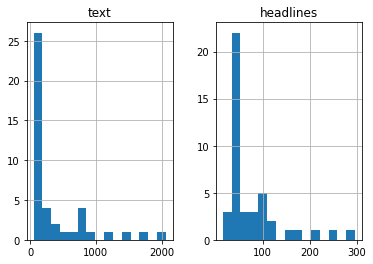

In [10]:
# distribution of sequences
import matplotlib.pyplot as plt

text_word_count = []
headlines_word_count = []

for i in cleaned_text:
    text_word_count.append(len(i.split()))
for i in cleaned_headlines:
    headlines_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text': text_word_count, 'headlines': headlines_word_count})
length_df.hist(bins=15)
plt.show()

In [11]:
count = 0
for i in cleaned_text:
    if(len(i.split())<=55):
        count += 1
print(count/len(cleaned_text))

0.046511627906976744


In [12]:
max_text_len=55
max_headlines_len=15

cleaned_text = np.array(cleaned_text)
cleaned_headlines = np.array(cleaned_headlines)

short_text=[]
short_headlines=[]

for i in range(len(cleaned_text)):
    
    #if(len(cleaned_headlines[i].split())<=max_headlines_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_headlines.append(cleaned_headlines[i])

df=pd.DataFrame({'text':short_text,'headlines':short_headlines})
df['headlines'] = df['headlines'].apply(lambda x : 'sostok '+ x + ' eostok')

print(df['text'])
print(df['headlines'])
print(short_text)

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split((df['text']),(df['headlines']),test_size=0.2)

0     ability sensing temperature electronic circuits means necessity convert temperature change measureable electric characteristics e g resistance voltage change several different devices technologies...
1     transistor three terminal solid state device formed connecting two diodes back back hence got two pn junctions three terminals drawn three semiconductor materials present type connection offers tw...
2     diode two terminal semiconductor device allows current flow one direction basically negligible resistance one end high resistance another prevent current flowing ways thus diode like valve electri...
3     capacitor device storing electrical energy consisting two conductors close proximity insulated simple example storage device parallel plate capacitor positive charges total charge q deposited one ...
4     metal oxide silicon field effect transistors commonly known mosfets electronic devices used switch amplify voltages circuits current controlled device constructed three t

In [13]:
df.head()

,text,headlines
0,ability sensing temperature electronic circuits means necessity convert temperature change measureable electric characteristics e g resistance voltage change several different devices technologies...,sostok temperature measurement is one of the most important disciplines in sensor technology basically there are contactless and touchcontact measurement methods this article will make an overvi...
1,transistor three terminal solid state device formed connecting two diodes back back hence got two pn junctions three terminals drawn three semiconductor materials present type connection offers tw...,sostok a transistor is a semiconductor device used to amplify or switch electronic signals and electrical power it is composed of semiconductor material usually with at least three terminals for ...
2,diode two terminal semiconductor device allows current flow one direction basically negligible resistance one end high resistance another prevent current flowing ways thus diode like valve electri...,sostok a diode is a two terminal semiconductor device that allows current to flow through in one direction only it basically has negligible resistance on one end and high resistance on another to...
3,capacitor device storing electrical energy consisting two conductors close proximity insulated simple example storage device parallel plate capacitor positive charges total charge q deposited one ...,sostok the capacitor is a device in which electrical energy can be stored it is an arrangement of two conductor generally carrying charges of equal magnitudes and opposite sign and separated by a...
4,metal oxide silicon field effect transistors commonly known mosfets electronic devices used switch amplify voltages circuits current controlled device constructed three terminals terminals mosfet ...,sostok the mosfet metal oxide semiconductor field effect transistor transistor is a semiconductor device that is widely used for switching purposes and for the amplification of electronic signal...


In [14]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
x_voc

% of rare words in vocabulary: 71.40912185159974
Total Coverage of rare words: 20.338640043173235


841

In [15]:

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_headlines_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_headlines_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

y_tokenizer.word_counts['sostok'],len(y_tr)

% of rare words in vocabulary: 89.26767676767676
Total Coverage of rare words: 41.981651376146786


(34, 34)

In [16]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [17]:
from keras import backend as K 
K.clear_session()

latent_dim = 200
embedding_dim=110

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 1)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 1)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55)]         0                                            
____________________________________________________________________

In [18]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
1/1 [==============================] - 40s 40s/step - loss: 4.4547 - val_loss: 4.4331
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 4.4271 - val_loss: 4.2018
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 4.1986 - val_loss: 4.6467
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 4.5862 - val_loss: 3.9831
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 3.9304 - val_loss: 3.8580
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 3.8041 - val_loss: 3.8581
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 3.7808 - val_loss: 3.8220
Epoch 8/50
1/1 [==============================] - 2s 2s/step - loss: 3.7325 - val_loss: 3.8260
Epoch 9/50
1/1 [==============================] - 2s 2s/step - loss: 3.7108 - val_loss: 3.8377
Epoch 00009: early stopping


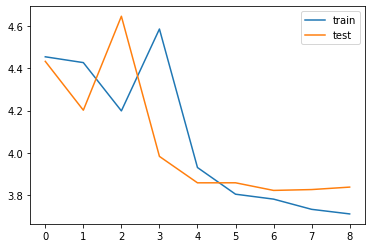

In [19]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [20]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
     # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_headlines_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [21]:
for i in range(0,20):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: show discrete power density cpm signals become psp also show class cpm use real number modulation index h structure cpm maximum allowed number states receiver energy bandwidth performance cpm using time limited psp compared conventional cpm time psp results show number states receiver bandwidth cpm could conventional cpm 6 db coding gain h 1 many 
Original summary: a phase one of the two of the current from the two of the 
Predicted summary:  the the the the the the the the


Review: word means communication basic step information example needs help communication bridge communication defined process information means etc two information means etc termed hence signal source energy information signal communication receiver electrical electromagnetic wave distance message termed signal communication systems depending characteristics signals mainly classified two types analog digital analog digital signals classified shown following figure 
Original summary: is in analog signal dat

Predicted summary:  the the the the the the the the


Review: makes input either high low high signal switch allowing carrier wave hence output carrier signal high input low input switch allowing voltage hence output low band filter pulse depending upon amplitude phase characteristics band filter pulse filter ask two types ask techniques ask ask clock frequency clock frequency receiver known method frequency gets otherwise known 
Original summary: in an a one or is by a carrier wave a frequency for a 
Predicted summary:  the the the the the the the the


Review: form modulation known quadrature amplitude modulation phase amplitude varied provide additional phase modulation similar frequency modulation important technique digital communication systems radio fm radio phase modulation different means common term turns phase modulation digital way pm radio common fm radio simply difference phase modulation frequency modulation fm pm considered two related modulation passed sine function 
O